In [1]:
from fastai.vision.all import *
import timm, cv2
from dice import DiceLoss
import segmentation_models_pytorch as smp
import albumentations as A
from sklearn.model_selection import train_test_split
import kornia as K

In [2]:
def get_aug(img_sz, p=1.0):
    return A.Compose([
        A.Resize(img_sz, img_sz),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9, 
                         border_mode=cv2.BORDER_REFLECT),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.PiecewiseAffine(p=0.3),
        ], p=0.3),
        A.OneOf([
            A.HueSaturationValue(10,15,10),
            A.CLAHE(clip_limit=2),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
    ], p=p)

def val_aug(img_sz):
    return A.Resize(img_sz, img_sz)

In [3]:
class SegmentationDataset:
    def __init__(self, fs, augs):
        self.fs = fs
        self.augs = augs
        
    @classmethod
    def from_folder(cls, root, augs, sz):
        cls.root = Path(root)
        fs = get_image_files(cls.root/'images')
        cls.c = (cls.root/'classes.txt').read_text().split('\n')
        cls.enc = {j:i for i,j in enumerate(cls.c)}
        x_train, x_val = train_test_split(fs, test_size=0.2, random_state=2021, shuffle=True)
        return cls(x_train, augs[0](sz)), cls(x_val, augs[1](sz))
        
    def __getitem__(self, idx):
        img = np.array(Image.open(self.fs[idx]).convert('RGB'))
        mask = np.array(Image.open(os.path.join(self.root, 'masks', self.fs[idx].name)).convert('L'))
        samp = {'image': img, 'mask': mask}
        samp = self.augs(**samp)
        img, mask = samp['image'], samp['mask']
        img, mask = torch.from_numpy(img).permute(2, 0, 1), torch.from_numpy(mask)
        return img, mask
    
    def __len__(self):
        return len(self.fs)

In [4]:
path = '/mnt/data/seg/bin'

In [5]:
train_ds, val_ds = SegmentationDataset.from_folder(path, [get_aug, val_aug], 256)

In [6]:
dls = DataLoaders.from_dsets(train_ds, val_ds, batch_size=64, pin_memory=True, num_workers=4).cuda()

In [7]:
model = smp.Unet(
    encoder_name="tu-resnet34d",        
    encoder_weights="imagenet",     
    in_channels=3,                 
    classes=5,                     
).cuda()

In [8]:
class ImgProcCB(Callback):
    def before_batch(self):
        xb = K.normalize(self.xb[0]/255.0, 
                         mean=torch.tensor((0.485, 0.456, 0.406)), 
                         std=torch.tensor((0.229, 0.224, 0.225)))
        self.learn.xb = (xb,)
        self.learn.yb = [self.yb[0].long()]

In [9]:
unet_splitter = lambda m: L(m.encoder, nn.Sequential(m.decoder, m.segmentation_head)).map(params)
learn = Learner(dls, model, 
                loss_func = DiceLoss(mode='multiclass', log_loss=True), 
#                 loss_func = K.losses.DiceLoss(),
                splitter=unet_splitter, 
                cbs = [TerminateOnNaNCallback(), ImgProcCB()],
                metrics=DiceMulti).to_fp16()
learn.freeze()

/home/ubuntu/anaconda3/envs/torchdl0/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


SuggestedLRs(valley=0.005248074419796467)

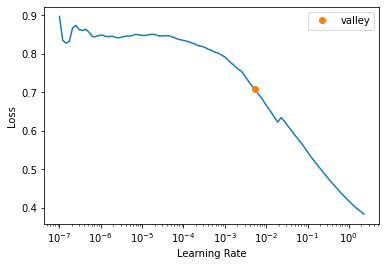

In [10]:
learn.lr_find()

In [11]:
# K.losses.DiceLoss?

In [12]:
learn.fit_one_cycle(6, 1e-2)

epoch,train_loss,valid_loss,dice_multi,time
0,0.122312,0.053899,0.884663,01:04
1,0.047061,0.029721,0.932366,01:01
2,0.033171,0.023872,0.944867,01:02
3,0.029345,0.026341,0.939564,01:01
4,0.026119,0.020563,0.952253,01:01
5,0.023323,0.019975,0.953590,01:03


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(24, slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,dice_multi,time
0,0.023827,0.020182,0.953102,01:09
1,0.023293,0.019956,0.953532,01:09
2,0.022413,0.019054,0.955690,01:10
3,0.021878,0.018188,0.957449,01:12
4,0.021434,0.018517,0.956726,01:10
5,0.020856,0.018114,0.957776,01:09
6,0.020933,0.017532,0.958931,01:10
7,0.019709,0.017175,0.959834,01:12
8,0.019848,0.017347,0.959363,01:10
9,0.019485,0.018157,0.957546,01:09


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warn